In [1]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [2]:
gdf = gpd.read_file("../data/SANGIS/BUSINESS_SITES/BUSINESS_SITES.shp")

In [3]:
gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y

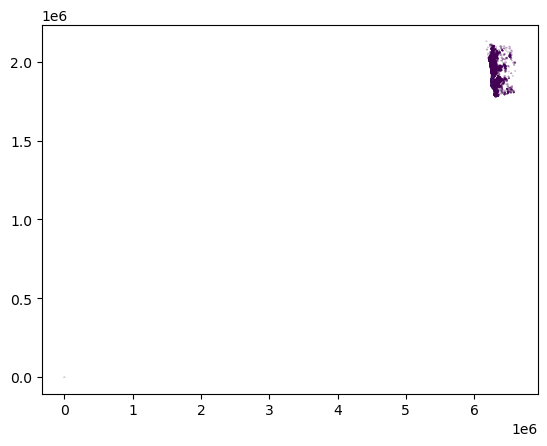

In [4]:
hexes = matplotlib.pyplot.hexbin( x= gdf['x'], y=gdf['y'],mincnt=1,gridsize=3970)

In [5]:
hexbins = gpd.points_from_xy(x=[i[0] for i in hexes.get_offsets()],y=[i[1] for i in hexes.get_offsets()])[1:]

In [6]:
left_merge = gpd.GeoDataFrame(hexbins, geometry=0)

In [7]:
full_merge = gpd.sjoin_nearest(left_merge,gdf,how='right')

/var/folders/9y/511s41v52w36jc3xv1hv8l2m0000gn/T/ipykernel_14644/318931066.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:2230

  full_merge = gpd.sjoin_nearest(left_merge,gdf,how='right')


In [8]:
index_and_counts = full_merge.groupby('index_left').count().sort_values(by='x').reset_index()[['index_left','APN',]]

In [9]:
def get_x(index):
    return hexbins[index].x
def get_y(index):
    return hexbins[index].y

In [10]:
index_and_counts['x'] = index_and_counts['index_left'].apply(get_x)
index_and_counts['y'] = index_and_counts['index_left'].apply(get_y)
index_and_counts['geometry'] = gpd.points_from_xy(index_and_counts['x'], index_and_counts['y'])

In [11]:
df = gpd.GeoDataFrame(index_and_counts)

<Axes: >

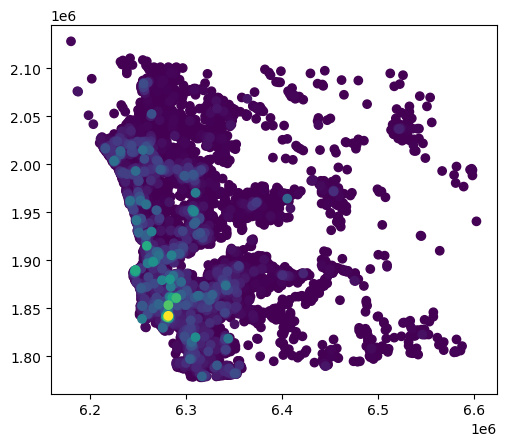

In [12]:
df.plot(column='APN')

<Axes: >

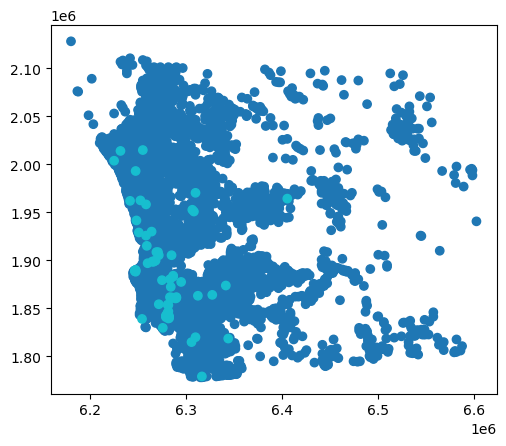

In [13]:
# idea 1 - could we use 70 biggest maxima as centers?
df['is_center'] = df['APN']>df['APN'].sort_values(ascending=False).reset_index(drop=True)[70]
df.plot(column='is_center')

In [14]:
# clustering based off local maxima centers using kmeans
cluster_centers = df[df['is_center']==True][['x', 'y']].values
other_points = df[['x', 'y']].values
k = len(cluster_centers)
kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
kmeans.fit(other_points)
df['cluster'] = kmeans.labels_

<Axes: >

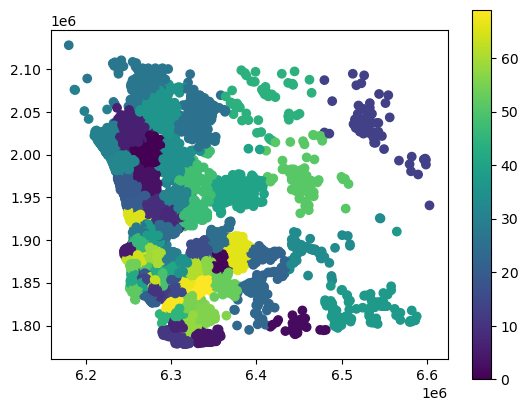

In [15]:
df.plot(column='cluster', legend=True)

<Axes: >

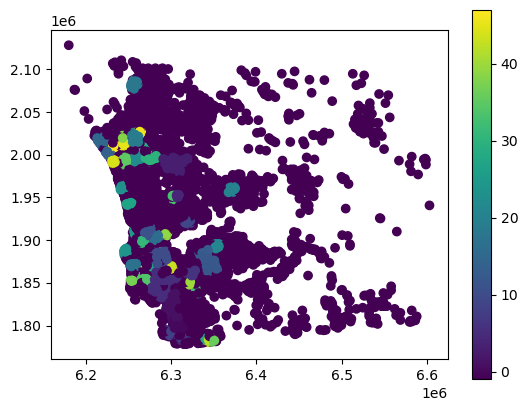

In [16]:
# other idea - what does python have available? 
# basic dbscan clustering on distance
scaler = StandardScaler()
df['scaled_weight'] = scaler.fit_transform(df[['APN']])
features = df[['x', 'y','APN']]
dbscan = DBSCAN(eps=2500, min_samples=20)
df['cluster_label'] = dbscan.fit_predict(features)
df.plot(column='cluster_label', legend=True)

<Axes: >

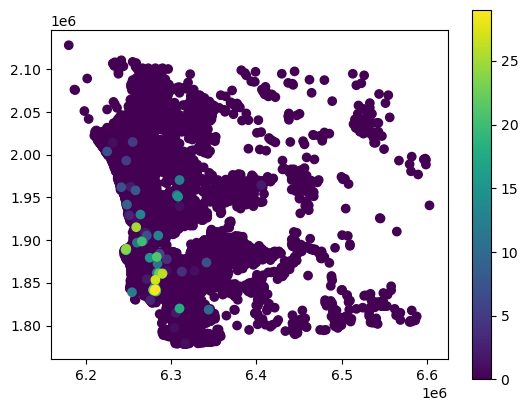

In [17]:
# other idea - db scan but for just the counts to find local maxima?
scaler = StandardScaler()
df['scaled_weight'] = scaler.fit_transform(df[['APN']])
features = df[['APN']]
dbscan = DBSCAN(eps=1, min_samples=1)
df['cluster_label'] = dbscan.fit_predict(features)
df.plot(column='cluster_label', legend=True)